## Index

[1 Importing packages](#1)<br>
[2 Read CSV train/test files into DataFrame](#2)<br>
[3 Data Preprocessing](#3)<br>
    <ul>
        <li>[3.1 Missing Values](#31)</li>
        <li>[3.2 Drop Features Using Pearson Correlation](#32)</li>
    </ul>
[4 Regressions and Results](#4)<br>
    <ul>
        <li>[4.1 Separate the dataset into train and test](#41)</li>
        <li>[4.2 Check categorical columns](#42)</li>
        <li>[4.3 Check zero variance features](#43)</li>
        <li>[4.4 Feature Selection](#44)</li>
        <li>[4.5 Running Machine Learning Models](#45)</li>
        <li>[4.6 Evaluating the Model ](#46)</li>
    </ul>
[5. Submission](#5)<br>

<a id='1'></a>
<div class="alert alert-block alert-danger">
<h2>1 Importing packages</h2>
</div>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math, time, datetime
# from math import sqrt
import numpy as np 
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import missingno as msno
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import (confusion_matrix, mean_squared_error, r2_score, classification_report,
            roc_auc_score, roc_curve, precision_recall_curve, auc, log_loss, accuracy_score, f1_score)
from sklearn.feature_selection import (mutual_info_classif, SelectKBest, chi2, RFE, RFECV)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

<a id='2'></a>
<div class="alert alert-block alert-danger">
   <h2>
    2 Read CSV train/test files into DataFrame
    </h2>
</div>

In [ ]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

y = train['Survived']
train = train.drop('Survived', axis=1)
train.tail()

In [ ]:
test.head()

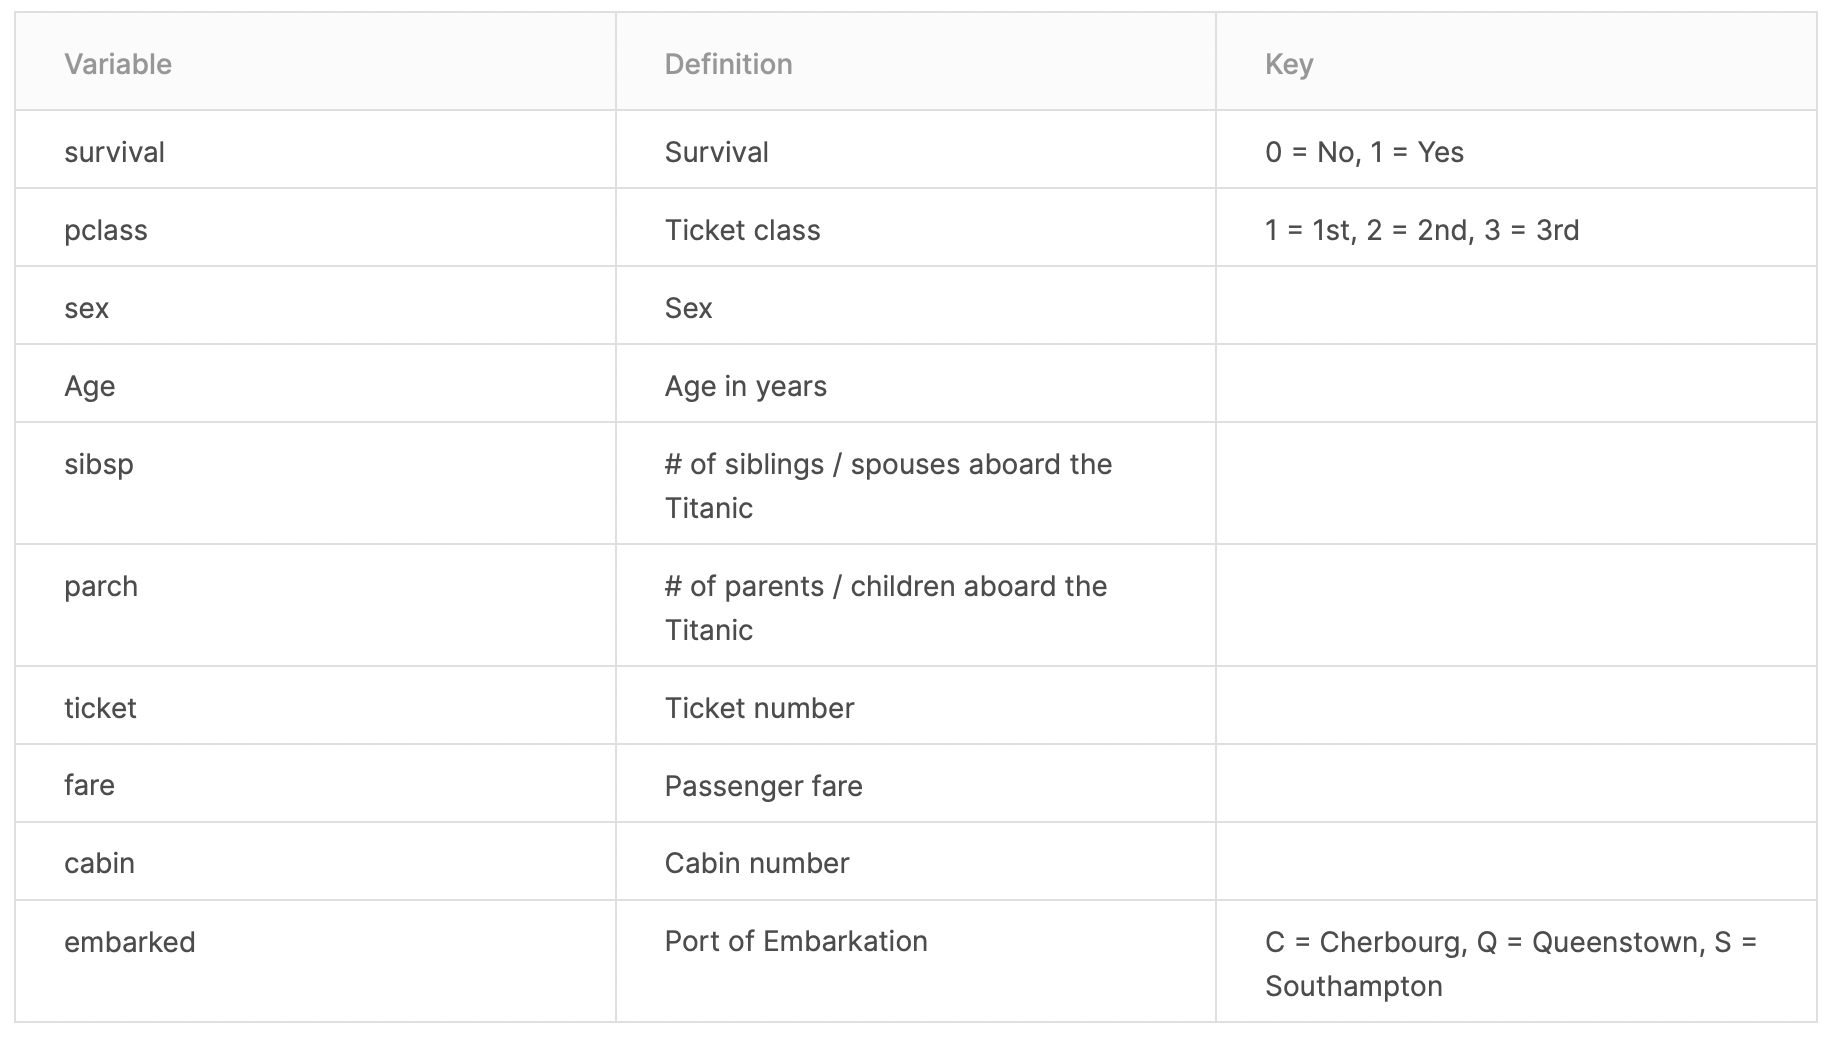

pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>
<br>
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>
sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>
parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

# The goal

The goal is to predict the target variable(Survived) using logistic regression.

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
ax.barh(y.unique(), y.value_counts(), align='center', color=['red', 'green'])
ax.text(530, 0, y.value_counts()[0], ha='center', va='center', color='w', size=20)
ax.text(320, 1, y.value_counts()[1], ha='center', va='center', color='w', size=20)
ax.set_yticks(y.unique())
ax.set_yticklabels(y.unique())
ax.invert_yaxis()
ax.set_ylabel('Survived')
ax.set_title('How many people survived?')

plt.show()

In [ ]:
# Combine train and test set for easy preprocessing
# REFERENCE: https://www.kaggle.com/abderrahimalakouche/first-kernel-on-kaggle-top-17
df = pd.concat([train, test]).reset_index(drop=True)
df.shape

<a id='3'></a>
## 3.Data Preprocessing

In [ ]:
## plot graphic of missing values
msno.matrix(df, figsize=(12, 6))

In [ ]:
# drop unnecessary columns, which won't be used in analysis and prediction
df = df.drop(['Ticket', 'Cabin'], axis=1)

In [ ]:
for col in df[df.notnull()]:
    unique_vals = df[col].value_counts()
    nr_values = len(unique_vals)
    if nr_values < 10:
        print(f'The number of values for feature {col} :{nr_values} -- {df[col].unique()}')
    else:
        print(f'The number of values for feature {col} :{nr_values}')

In [ ]:
df.isnull().sum()

In [ ]:
import re
title = []
for i in df['Name']:
#     print(re.search('([A-Z][a-z]+)\.',i))
    title.append(re.search('([A-Z][a-z]+)\.',i)[1])
df["Title"] = title
df.head()

In [ ]:
title_list = df['Title'].value_counts()

male_list = []
female_list = []
female_male_list = []
for ind in title_list.index:
    if not ind in ['Mr', 'Miss', 'Mrs']:
        title_uni = df[df['Title'] == ind]['Sex'].unique()
        if len(title_uni) == 1:
            if title_uni[0] == 'male':
                male_list.append(ind)
            else:
                female_list.append(ind)
        else:
            female_male_list.append(ind)
print(male_list)
print(female_list)
print(female_male_list)
title_list

In [ ]:
for male in male_list:
    df['Title']=df['Title'].replace([male],'Mr')

In [ ]:
df['Title'].value_counts()

In [ ]:
filt = ((df['Title'] == 'Ms') | (df['Title'] == 'Mlle') | (df['Title'] == 'Lady') | 
        (df['Title'] == 'Dona') | (df['Title'] == 'Mme') | (df['Title'] == 'Countess'))

df[filt][['Title', 'Age']]

In [ ]:
df['Title']=df['Title'].replace(['Mme', 'Ms', 'Mlle'],'Miss')
df['Title']=df['Title'].replace(['Lady', 'Countess', 'Dona'],'Mrs')

df['Title'].value_counts()

In [ ]:
filt = (df['Title'] == 'Dr')
df[filt][['Title', 'Sex', 'Age']]

In [ ]:
df.loc[796, 'Title'] = 'Mrs'
df['Title']=df['Title'].replace(['Dr'],'Mr')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
ax.barh(df['Title'].value_counts().index, df['Title'].value_counts().values, align='center')
ax.set_ylabel('Title')
plt.show()

In [ ]:
Title_col_names = []
one_hot_encoded_Title = pd.get_dummies(df['Title'])
for i in one_hot_encoded_Title.columns:
    Title_col_names.append(f'Title_{i}')
one_hot_encoded_Title.columns = Title_col_names
one_hot_encoded_Title.head()

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
ax.barh(df['Pclass'].value_counts().index, df['Pclass'].value_counts().values, align='center')
ax.set_ylabel('Pclass')
plt.show()

In [ ]:
Pclass_col_names = []
one_hot_encoded_Pclass = pd.get_dummies(df['Pclass'])
for i in one_hot_encoded_Pclass.columns:
    Pclass_col_names.append(f'Pclass_{i}')
one_hot_encoded_Pclass.columns = Pclass_col_names
one_hot_encoded_Pclass.head()

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
ax.barh(df['Sex'].value_counts().index, df['Sex'].value_counts().values, align='center')
ax.set_ylabel('Sex')
plt.show()

In [ ]:
Sex_col_names = []
one_hot_encoded_Sex = pd.get_dummies(df['Sex'])
for i in one_hot_encoded_Sex.columns:
    Sex_col_names.append(f'Sex_{i}')
one_hot_encoded_Sex.columns = Sex_col_names
one_hot_encoded_Sex.head()

In [ ]:
df = pd.concat([df, one_hot_encoded_Title, one_hot_encoded_Pclass, one_hot_encoded_Sex], axis = 1)
df.drop(['Title', 'Pclass', 'Sex', 'Name'], axis=1, inplace=True)
df.head()

<a id='31'></a>
<div class="alert alert-block alert-info">
   <h3>
        3.1 Missing Values
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        3.1.1 Fare
    </h4>
</div>

#### 3.1.1.1 Missing values in test data

In [ ]:
# the Pclass of the Fare missing value is Pclass_3
df[df['Fare'].isnull()]

In [ ]:
# the mean of Fare for the Pclass 3
df_Pclass_mean = df[df['Pclass_3'] == 1]['Fare'].mean()

# fill NaN value in Fare column with mean
df.loc[1043, 'Fare'] = df_Pclass_mean

df.isnull().sum()

<div class="alert alert-block alert-success">
    <h4>
        3.1.2 Age
    </h4>
</div>

In [ ]:
df["Age"].fillna(df["Age"].mean(),inplace=True)

In [ ]:
df.isnull().sum()

<div class="alert alert-block alert-success">
    <h4>
        3.1.3 Embarked
    </h4>
</div>

#### 3.1.2.1 Missing values in train data

In [ ]:
# getting the Pclass of the Embarked missing value
Pclass_embarked_mis = df[df['Embarked'].isnull()]['Pclass_1'].values
print(Pclass_embarked_mis)
print("----------------------------")
# distribution in Embarked by their Pclass
print(df[df['Pclass_1'] == 1]['Embarked'].value_counts())

# for Pclass = 1, the most occurring values are S and C. 
# Therefore, one is filled as 'S', and the other as 'C'. 
df.loc[61, 'Embarked'] = 'S'
df.loc[829, 'Embarked'] = 'C'

df.isnull().sum()

In [ ]:
Embarked_col_names = []
one_hot_encoded_Embarked = pd.get_dummies(df['Embarked'])
for i in one_hot_encoded_Embarked.columns:
    Embarked_col_names.append(f'Embarked_{i}')
one_hot_encoded_Embarked.columns = Embarked_col_names
one_hot_encoded_Embarked.head()

In [ ]:
df = pd.concat([df, one_hot_encoded_Embarked], axis = 1)
df.drop(['Embarked'], axis=1, inplace=True)
df.head()

<a id='32'></a>
<div class="alert alert-block alert-info">
   <h3>
        3.2 Drop Features Using Pearson Correlation
   </h3>
</div>

In [ ]:
def create_heatmap(hm, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, 
    #                vmin=0, vmax=10, 
                   cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

In [ ]:
hm_X_train = df.corr()
create_heatmap(hm_X_train, figsize=(12, 8))

In [ ]:
#  to select highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df, 0.85)
corr_features

In [ ]:
df = df.drop(corr_features, axis=1)

In [ ]:
df.head()

<a id='4'></a>
<div class="alert alert-block alert-danger">
   <h2>
    4. Regressions and Results
    </h2>
</div>

In [ ]:
df = df.sort_values(by='PassengerId')
X = df[df['PassengerId'] < 892]
X = X.drop('PassengerId', axis=1)

X_kaggle = df[df['PassengerId'] >= 892]
X_kaggle = X_kaggle.drop('PassengerId', axis=1)

print(X.shape)
print(X_kaggle.shape)

<a id='41'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.1 Drop Outliers
   </h3>
</div>

In [ ]:
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)


    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()
#     print(sorted(outliers))

In [ ]:
box_plot(X['Age'], 'Age')

In [ ]:
outliers_index_age = X[X['Age'] > 71].index
print(outliers_index_age)
X1 = X.drop(outliers_index_age, axis=0)

In [ ]:
box_plot(X1['Fare'], 'Fare')

In [ ]:
outliers_index_fare = X1[X1['Fare'] > 500].index
print(outliers_index_fare)
X2 = X1.drop(outliers_index_fare, axis=0)

In [ ]:
box_plot(X2['SibSp'], 'SibSp')

In [ ]:
outliers_index_sibSp = X2[X2['SibSp'] > 5].index
print(outliers_index_sibSp)
X3 = X2.drop(outliers_index_sibSp, axis=0)

In [ ]:
box_plot(X3['Parch'], 'Parch')

In [ ]:
outliers_index_parch = X3[X3['Parch'] > 5].index
print(outliers_index_parch)
X4 = X3.drop(outliers_index_parch, axis=0)

In [ ]:
outlier_list = (list(outliers_index_age) + list(outliers_index_fare) + 
                list(outliers_index_sibSp) + list(outliers_index_parch))
outlier_list

In [ ]:
import itertools
from sklearn.linear_model import LogisticRegression
index_dropped = []
train_scores = []
test_scores = []
for L in range(0, len(outlier_list)+1):
    for subset in itertools.combinations(outlier_list, L):
        ind = list(subset)
        if len(ind) > 6:
            df1=df.drop(ind)
            y1=y.drop(ind)
            df1["Age"]=np.log(df1["Age"])
            X = df1[df1['PassengerId'] < 892]
            X = X.drop('PassengerId', axis=1)
            X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.25, random_state=0)
            lr=LogisticRegression(random_state=40)
            lr.fit(X_train, y_train)
            train_scores.append(lr.score(X_train,y_train))
            test_scores.append(lr.score(X_test,y_test))
            index_dropped.append(ind)

In [ ]:
df_ind_acc = pd.DataFrame({'index':index_dropped, 'train_scores':train_scores, 'test_scores':test_scores})
df_ind_acc = df_ind_acc.sort_values(by=['train_scores', 'test_scores'], ascending=False).reset_index(drop=True)
df_ind_acc.head()

In [ ]:
df_ind_acc[(df_ind_acc['train_scores'] > 0.83) & (df_ind_acc['test_scores'] > 0.819)]

In [ ]:
#now we gpoing to remove outliers
ind_dropped = [851, 679, 737, 159, 324, 792, 846, 863]
df1=df.drop(ind_dropped)
y1=y.drop(ind_dropped)

<a id='42'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.2 Separate the dataset into train and test
   </h3>
</div>

In [ ]:
X = df1[df1['PassengerId'] < 892]
X = X.drop('PassengerId', axis=1)

X_kaggle = df1[df1['PassengerId'] >= 892]
X_kaggle = X_kaggle.drop('PassengerId', axis=1)

print(X.shape)
print(y1.shape)

In [ ]:
X["Age"]=np.log(X["Age"])

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.25, random_state=0)

In [ ]:
#hyperparameter tuning of logistic regression
from sklearn.model_selection import GridSearchCV
param = {
         'penalty':['l1','l2'],
         'C':[0.001, 0.01, 0.1, 1, 10, 20,100, 1000]
}
cv=GridSearchCV(LogisticRegression(),param,cv=5,n_jobs=-1)
cv.fit(X_train,y_train)

print(cv.score(X_train,y_train))
print(cv.score(X_test,y_test))

# cv.predict(x_test)

In [ ]:
# best_parameters
print("Best CV params", cv.best_params_)  

In [ ]:
# best_score
print("Best CV score", cv.best_score_)

In [ ]:
# best_estimators
best_lr = cv.best_estimator_
best_lr

<a id='42'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.2 Check categorical columns
   </h3>
</div>

In [ ]:
### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(df)
df.columns[var_thres.get_support()]

In [ ]:
constant_columns = [column for column in df.columns
                    if column not in df.columns[var_thres.get_support()]]

print(len(constant_columns))

<a id='44'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.4 Feature Selection
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        4.4.1 SelectKBest_mutual_info_classif
    </h4>
</div>

In [ ]:
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

In [ ]:
# select the  top k important features
KBest_mutual = SelectKBest(mutual_info_classif, k=8)
KBest_mutual.fit(X_train, y_train)
KBest_cols = X_train.columns[KBest_mutual.get_support()]
print(KBest_cols)

KBest_df = pd.DataFrame({'Feature':list(X_train.columns),
                                     'Scores':KBest_mutual.scores_})
KBest_df.sort_values(by='Scores', ascending=False).reset_index(drop=True)

<div class="alert alert-block alert-success">
    <h4>
        4.4.2 SelectKBest_chi2
    </h4>
</div>

In [ ]:
# KBest_chi2 = SelectKBest(chi2, k=8).fit(X_train, y_train)
# KBest_chi2_cols = X_train.columns[KBest_chi2.get_support()]
# print(KBest_chi2_cols)

# KBest_chi2_df = pd.DataFrame({'Feature':list(X_train.columns), 'Scores':KBest_chi2.scores_})
# KBest_chi2_df = KBest_chi2_df.sort_values(by='Scores', ascending=False).reset_index(drop=True)
# KBest_chi2_df

<div class="alert alert-block alert-success">
    <h4>
        4.4.3 RFE
    </h4>
</div>

In [ ]:
# GBC_reg = GradientBoostingClassifier()
rf = RandomForestClassifier(n_estimators=100, random_state=0, criterion = 'entropy')

rfe = RFE(estimator=RandomForestClassifier(), step=1, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)
rfe_cols = X_train.columns[rfe.get_support()]
print(rfe_cols)

rfe_df = pd.DataFrame({'Feature':list(X_train.columns), 'Scores':rfe.ranking_})
rfe_df = rfe_df.sort_values(by='Scores', ascending=True).reset_index(drop=True)
rfe_df

<div class="alert alert-block alert-success">
    <h4>
        4.4.4 RFECV
    </h4>
</div>

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(C=20), step=1, cv=10, scoring='accuracy')
rfecv = rfecv.fit(X_train.values, y_train)
rfecv_cols = X_train.columns[rfecv.get_support()]
print(rfecv_cols)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
new_cols = ['Age', 'SibSp', 'Parch', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Pclass_1', 'Pclass_3', 
            'Embarked_Q', 'Embarked_S']

<a id='45'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.5 Running Machine Learning Models
   </h3>
</div>

In [ ]:
import itertools

def feature_selection(model, cols):
    best_cols = []
    best_acc = []
    best_mse = []
    best_r2 = []
    
    stuff = cols
    for L in range(0, len(cols)+1):
        for subset in itertools.combinations(stuff, L):
            cols = list(subset)
            if len(cols) > 10:
                # Cross Validation 
                y_pred_test = cross_val_predict(model, X_test[cols], y_test, cv=5, n_jobs = -1)
                # Cross-validation accuracy metric
                acc_cv = round(accuracy_score(y_test, y_pred_test) * 100, 2)
                best_acc.append(acc_cv)
                best_cols.append(cols)

    best_zip = zip(best_cols, best_acc)
    df_best_acc = pd.DataFrame(best_zip, columns=['columns', 'accuracy'])
    df_best_acc = df_best_acc.sort_values('accuracy', ascending = False).reset_index(drop=True)
    pd.set_option('max_colwidth', -1)

    return df_best_acc

<div class="alert alert-block alert-success">
    <h4>
        4.5.1 Logistic
    </h4>
</div>

In [ ]:
from sklearn.linear_model import LogisticRegression

#hyperparameter tuning of logistic regression
from sklearn.model_selection import GridSearchCV
param = {
         'penalty':['l1','l2'],
         'C':[0.001, 0.01, 0.1, 1, 10, 20,100, 1000]
}
cv_lg=GridSearchCV(LogisticRegression(),param,cv=5,n_jobs=-1)
cv_lg.fit(X_train,y_train)

lg_train_score = cv_lg.score(X_train, y_train)
lg_test_score = cv_lg.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", lg_train_score)
print("Test accuracy of best grid search hypers:", lg_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.2 Random Forest
    </h4>
</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10,min_samples_split=9)
rf.fit(X_train,y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", rf_train_score)
print("Test accuracy of best grid search hypers:", rf_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.3 Naive Bayes
    </h4>
</div>

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [ ]:
bNB = BernoulliNB()
bNB.fit(X_train, y_train)

bNB_train_score = bNB.score(X_train, y_train)
bNB_test_score = bNB.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", bNB_train_score)
print("Test accuracy of best grid search hypers:", bNB_test_score)

In [ ]:
# mNB = MultinomialNB()
# # df_bNB = feature_selection(bNB, X_train.columns)
# # df_bNB.head()

# mNB.fit(X_train, y_train)
# print("Test accuracy of best grid search hypers:", mNB.score(X_train, y_train))
# print("Test accuracy of best grid search hypers:", mNB.score(X_test, y_test))

In [ ]:
gNB = GaussianNB()
gNB.fit(X_train, y_train)

gNB_train_score = gNB.score(X_train, y_train)
gNB_test_score = gNB.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", gNB_train_score)
print("Test accuracy of best grid search hypers:", gNB_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.4 SVM
    </h4>
</div>

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=0.5, gamma=0.1, random_state=42, probability=True)
svm.fit(X_train, y_train)

svm_train_score = svm.score(X_train, y_train)
svm_test_score = svm.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", svm_train_score)
print("Test accuracy of best grid search hypers:", svm_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.5 k-Nearest Neighbours
    </h4>
</div>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

acc_list = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_mean = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy').mean()
    acc_list.append(knn_mean)
    
plt.figure(figsize=(8,4))
plt.plot(range(1,40),acc_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
k_max_list = [i for i in acc_list if i >= 0.76]
k_max_list

In [ ]:
k_max = acc_list.index(0.7688828584350973)
print(k_max)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=k_max)
knn.fit(X_train, y_train)

knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", knn_train_score)
print("Test accuracy of best grid search hypers:", knn_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.6 Stochastic Gradient Descent
    </h4>
</div>

In [ ]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()

# df_sgdc = feature_selection(sgdc, X_train.columns)
# df_sgdc.head()

parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge','log'], 'penalty':['l1','l2']}
cv_sgdc = GridSearchCV(sgdc, parameters, cv=10)
cv_sgdc.fit(X_train, y_train)

sgdc_train_score = cv_sgdc.score(X_train, y_train)
sgdc_test_score = cv_sgdc.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", sgdc_train_score)
print("Test accuracy of best grid search hypers:", sgdc_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.7 Gradient Boosting Trees
    </h4>
</div>

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

gbc_train_score = gbc.score(X_train, y_train)
gbc_test_score = gbc.score(X_test, y_test)
print("Test accuracy of best grid search hypers:", gbc_train_score)
print("Test accuracy of best grid search hypers:", gbc_test_score)

<div class="alert alert-block alert-success">
    <h4>
        4.5.9 Model_Selection - Final
    </h4>
</div>

In [ ]:
df_models_acc = pd.DataFrame({
    'Model': ['lg', 'rf', 'gNB', 'svm', 'knn', 'sgdc', 'gbc'],
    'Accuracy_Train': [lg_train_score, rf_train_score, gNB_train_score, svm_train_score, 
                       knn_train_score, sgdc_train_score, gbc_train_score],
    'Accuracy_Test': [lg_test_score, rf_test_score, gNB_test_score, svm_test_score, 
                      knn_test_score, sgdc_test_score, gbc_test_score],
})
df_models_acc.sort_values(by='Accuracy_Test', ascending=False)

<a id='46'></a>
<div class="alert alert-block alert-info">
   <h3>
        4.6 Evaluating the Model
   </h3>
</div>

In [ ]:
df_lg = feature_selection(cv_lg, X_train.columns)
df_lg.head()

In [ ]:
cols_final = ['Age', 'SibSp', 'Parch', 'Fare', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Pclass_1', 'Pclass_3', 'Embarked_S', 'Embarked_C']

# cols_final = X_train.columns
X_train_final = X_train[cols_final]
X_test_final = X_test[cols_final]
X_kaggle_final = X_kaggle[cols_final]
model = GridSearchCV(LogisticRegression(),param,cv=5,n_jobs=-1)

model.fit(X_train_final, y_train)
y_pred_train = model.predict(X_train_final)
y_pred_test = model.predict(X_test_final)

pred_proba_train = model.predict_proba(X_train_final)
pred_proba_test = model.predict_proba(X_test_final)

print('='*7)
print('TRAIN')
print('='*7)
print('')

cm = confusion_matrix(y_train, y_pred_train).T
TP, FP, FN, TN = cm.ravel()
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print('The True Positive Rate is: {:.2%}'.format(TPR))
# Specificity, selectivity or true negative rate (TNR)
TNR = TN / (TN + FP)
print('The True Negative Rate is: {:.2%}'.format(TNR))
print('='*10)

print('='*7)
print('TEST')
print('='*7)
print('')
cm = confusion_matrix(y_test, y_pred_test).T
TP, FP, FN, TN = cm.ravel()
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print('The True Positive Rate is: {:.2%}'.format(TPR))
# Specificity, selectivity or true negative rate (TNR)
TNR = TN / (TN + FP)
print('The True Negative Rate is: {:.2%}'.format(TNR))
print('='*10)

<div class="alert alert-block alert-success">
    <h4>
        4.6.1 Confusion matrix
    </h4>
</div>

In [ ]:
def confusion_matrix_func(cm, cm_title):
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(cm.tolist())))
    ax.set_yticks(np.arange(len(cm.tolist())))


    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = ax.text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")

    # Let the horizontal axes labeling appear on top.
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    plt.xlabel('Actual value', size=16)
    plt.ylabel('Predicted value', size=16)
    plt.title(cm_title, size=20, x=0.2, y=1.2)
    plt.show()

In [ ]:
def Confusion_matrix_metrics(TP, FP, FN, TN):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    print('The True Positive Rate is: {:.2%}'.format(TPR))
    # Specificity, selectivity or true negative rate (TNR)
    TNR = TN / (TN + FP)
    print('The True Negative Rate is: {:.2%}'.format(TNR))
    print('='*10)

    # accuracy (ACC)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    print('The Accuracy is: {:.2%}'.format(ACC))
    # balanced accuracy (BA)
    BA = (TPR + TNR) / 2
    print('The Balanced Accuracy is: {:.2%}'.format(BA))
    print('='*10)

    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    print('The Precision is: {:.2%}'.format(PPV))
    # negative predictive value (NPV)
    NPV = TN / (TN + FN)
    print('The Negative Predictive Value is: {:.2%}'.format(NPV))
    # false discovery rate (FDR)
    FDR = 1 - PPV
    print('The False Discovery Rate is: {:.2%}'.format(FDR))
    # false omission rate (FOR)
    FOR = 1 - NPV
    print('The False Omission Rate is: {:.2%}'.format(FOR))
    print('='*10)

    # prevalence threshold (PT)
    PT = (math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1)
    print('The Prevalence Threshold is: {:.2}'.format(PT))
    # F1 score
    F1 = 2*TP / (2*TP + FP + FN)
    print('The F1 Score is: {:.2}'.format(F1))
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = ((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
    print('The Matthews Correlation Coefficient is: {:.2}'.format(MCC))
    print('='*10)

    # False positive rate or False alarm rate
    FPR = FP / (FP + TN)
    print('The False positive rate is: {:.2}'.format(FPR))
    # False negative rate or Miss Rate
    FNR = FN / (FN + TP)
    print('The False Negative Rate is: {:.2%}'.format(FNR))

In [ ]:
cm = confusion_matrix(y_train, y_pred_train).T
confusion_matrix_func(cm, cm_title="Confusion Matrix_Train")

In [ ]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
TP, FP, FN, TN = cm.ravel()
Confusion_matrix_metrics(TP, FP, FN, TN)

In [ ]:
cm_test = confusion_matrix(y_test, y_pred_test).T
confusion_matrix_func(cm_test, cm_title="Confusion Matrix_Test")

In [ ]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
TP, FP, FN, TN = cm_test.ravel()
Confusion_matrix_metrics(TP, FP, FN, TN)

<div class="alert alert-block alert-success">
    <h4>
        4.6.2 roc curve and auc
    </h4>
</div>

In [ ]:
# TRAIN
# calculate scores
lr_auc = roc_auc_score(y_train, pred_proba_train[:, 1])
# summarize scores
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, thresholds = roc_curve(y_train, pred_proba_train[:, 1])

# Evaluating model performance at various thresholds
df_roc = pd.DataFrame({
    'False Positive Rate': lr_fpr,
    'True Positive Rate': lr_tpr
}, index=thresholds)
df_roc.index.name = "Thresholds"
df_roc.columns.name = "Rate"


# TEST
# calculate scores
lr_auc_test = roc_auc_score(y_test, pred_proba_test[:, 1])
# summarize scores
# print('Logistic: ROC AUC=%.3f' % (lr_auc_test))
# calculate roc curves
lr_fpr_test, lr_tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test[:, 1])

# Evaluating model performance at various thresholds
df_roc_test = pd.DataFrame({
    'False Positive Rate': lr_fpr_test,
    'True Positive Rate': lr_tpr_test
}, index=thresholds_test)
df_roc_test.index.name = "Thresholds"
df_roc_test.columns.name = "Rate"


# GRAPH
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# row=0, col=0
axes[0, 0].plot(df_roc.iloc[:,0], df_roc.iloc[:,1], color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(df_roc.iloc[:,0], df_roc.iloc[:,1], 0, color='red', alpha=0.3)
axes[0, 0].plot(df_roc_test.iloc[:,0], df_roc_test.iloc[:,1], color='black', linewidth=2, 
                label=f'AUC_test={lr_auc_test:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

# index of the first threshold for which the sensibility > 0.90
idx = np.min(np.where(lr_tpr > 0.90))
axes[0, 0].plot([0,lr_fpr[idx]], [lr_tpr[idx],lr_tpr[idx]], 'k--', color='blue')
axes[0, 0].plot([lr_fpr[idx],lr_fpr[idx]], [0,lr_tpr[idx]], 'k--', color='blue')
# Annotation
axes[0, 0].annotate('(%.2f, %.2f)'%(lr_fpr[idx], lr_tpr[idx]),
            (lr_fpr[idx], lr_tpr[idx]), 
            xytext =(-2 * 50, -30),
            textcoords ='offset points',
            bbox = dict(boxstyle ="round", fc ="0.8"), 
            arrowprops = dict(arrowstyle = "->"))

axes[0, 0].set_xlabel('False Positive Rate', size=12)
axes[0, 0].set_ylabel('True Positive Rate (recall)', size=12)
axes[0, 0].legend(title='kNN')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# row=0, col=1
axes[0, 1].plot(df_roc.index[1:], df_roc["True Positive Rate"][1:], color='blue', linewidth=2, 
                label='TPR')
axes[0, 1].plot(df_roc_test.index[1:], df_roc_test["True Positive Rate"][1:], color='black', linewidth=2, 
                label='TPR_test')
axes[0, 1].plot(df_roc.index[1:], df_roc["False Positive Rate"][1:], color='orange', linewidth=2, 
                label='FPR')
axes[0, 1].plot(df_roc_test.index[1:], df_roc_test["False Positive Rate"][1:], color='black', linewidth=2, 
                label='FPR_test')

axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR and FPR at every threshold', color='red', size=14)

# row=1, col=0
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba_test[:, 1])

axes[1, 0].plot(recall, precision, color='green', linewidth=2, 
                label=f'PR_Curve (AUC={auc(lr_fpr, lr_tpr):.2f})')
axes[1, 0].fill_between(recall, precision, 0, color='green', alpha=0.3)

axes[1, 0].set_xlabel('Recall', size=12)
axes[1, 0].set_ylabel('Precision', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision-Recall Curve', color='red', size=14)

fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        4.6.3 Logarithmic loss
    </h4>
</div>

In [ ]:
# Running Log loss on training
print('The Log Loss on Training is: {:.2}'.format(log_loss(y_train, pred_proba_train[:, 1])))

# Running Log loss on testing
print('The Log Loss on Testing Dataset is: {:.2}'.format(log_loss(y_test, pred_proba_test[:, 1])))

<a id='5'></a>
<div class="alert alert-block alert-danger">
    <h2>
        5. Submission
    </h2>
</div>

In [ ]:
X_kaggle_final["Age"]=np.log(X_kaggle_final["Age"])
submission = gender_submission.drop('Survived', axis=1)
y_pred_kaggle = model.predict(X_kaggle_final)
submission['Survived'] = y_pred_kaggle
submission.head()

In [ ]:
df_gender_sub.head()

In [ ]:
# Are our test and submission dataframes the same length?
if len(submission) == len(gender_submission):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

In [ ]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
submission.to_csv('titanic_submission.csv', index=False)
print('Submission CSV is ready!')

In [ ]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("titanic_submission.csv")
submissions_check.head()